# Classification

In [321]:
import gensim 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

In [372]:
file_path = "C:/Users/Lenovo/Desktop/IT coding/IT project/news.json"
with open(file_path, "r") as file:
    data = json.load(file)
data = pd.DataFrame(data)

In [373]:
data['Labels'] = data['Category'].factorize()[0]

In [374]:
X = data['Cleaned_texts']
y = data['Labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We are going to use different embedding tecnhiques such as different classifiers and among them only the best combination will be used to classify unseen data by the alghoritm. The embedding techinques are:
- **TF-IDF** (Term Frequency-Inverse Document Frequency):

It provides a numerical representation of the importance of a term in a specific document relative to its significance across the entire collection.

The formula to compute it is: 
$$TF\text{-}IDF(t,d,D) = TF(t,d) \times IDF(t,D)$$
where: 
$$
\text{Term Frequency (TF): } \text{TF}(t, d) = \frac{\text{Number of occurrences of term } t \text{ in document } d}{\text{Total number of terms in document } d}
$$

$$
\text{Inverse Document Frequency (IDF): } \text{IDF}(t, D) = \log\left(\frac{\text{Total number of documents in } D}{\text{Number of documents containing term } t + 1}\right)
$$

- **Word2Vec** (Word Embedding):

Word2Vec is a neural network-based technique that represents words as vectors in a continuous vector space. The key idea is to learn distributed representations of words based on their context in the training data.
Words with similar meanings or contexts are mapped to vectors that are close to each other in the vector space.

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            text-align: center;
        }

        .centered-image {
            display: block;
            margin: 0 auto;
        }
    </style>
    <title>Doc2Vec Explanation</title>
</head>
<body>
    <p>Doc2Vec extends the Word2Vec concept to entire documents or paragraphs. It represents documents as vectors in a continuous space, allowing similarity comparisons between different documents. Like Word2Vec, Doc2Vec is trained using neural networks, and the resulting embeddings capture semantic information about the content of the documents.</p>
    
    <img src="doc2vec.jpeg" alt="Doc2Vec Image" class="centered-image" width="500" height="300">
</body>
</html>


<h1><center>
<img src='word2vec.jpeg'
     align = 'cenr'
     width="600"
     height='400' />
     

- **Doc2Vec** (Document Embedding):

Doc2Vec extends the Word2Vec concept to entire documents or paragraphs. It represents documents as vectors in a continuous space, allowing similarity comparisons between different documents.
Like Word2Vec, Doc2Vec is trained using neural networks, and the resulting embeddings capture semantic information about the content of the documents.

<h1><center>
<img src='doc2vec.png'
     align = 'center'
     width="600"
     height='400' />

### Models

The following code defines a function **vectorize** that takes a sentence and a Word2Vec or Doc2Vec model as input and returns a vector representation of the sentence based on the specified model. This function is used for converting sentences into vector representations. 

The function starts by splitting the input sentence into a list of words. 
- If the provided model is a Word2Vec model, it extracts word vectors for each word in the sentence that is present in the Word2Vec model. It then computes the average of these word vectors to obtain a vector representation for the entire document.
- If the model is a Doc2Vec model, it uses the _infer_vector_ method to obtain a vector representation for the sentence.
- If the model type is neither Word2Vec nor Doc2Vec, the function raises a _ValueError_ indicating that the model type is unsupported.


In [375]:
def vectorize(sentence, model):
    words = sentence.split()
    if isinstance(model, gensim.models.Word2Vec):
        # For Word2Vec, average word vectors
        words_vecs = [model.wv[word] for word in words if word in model.wv]
        if len(words_vecs) == 0:
            return np.zeros(model.vector_size)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)
    elif isinstance(model, gensim.models.Doc2Vec):
        return model.infer_vector(words)
    else:
        raise ValueError("Unsupported model type")

In order to perform classification, different embedding techniques are combined with various classifiers, including:
- Random Forest, 
- Logistic Regression, 
- Support Vector Machine, 
- Gradient Boosting. 

The function: **classification**  takes train and test datasets as input, along with the embedding technique and performs the following for each classifier:
1. Train the classifier on the training data.
2. Make predictions on the test data.
3. Compute accuracy, precision, recall, and F1 score.
4. Compute the confusion matrix.
5. Store the evaluation metrics in a DataFrame (results_df).
6. Store the confusion matrices in a list.

The function returns a tuple containing the DataFrame (**results_df**) and the list of confusion matrices.

In [326]:
labels = list(set(data['Category']))
classifiers = [
        ('RandomForest', RandomForestClassifier()),
        ('LogisticRegression', LogisticRegression(max_iter=1000, multi_class='auto')),
        ('SVM', SVC(probability=True)), 
        ('GradientBoosting', GradientBoostingClassifier())]

In [327]:
def classification(X_train_embedded, y_train, X_test_embedded, y_test, emb_name, classifiers):
    results_list = []
    confusion_matrices = []
    
    for clf_name, clf_model in classifiers:
        clf_model.fit(X_train_embedded, y_train)
        y_pred = clf_model.predict(X_test_embedded)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        confusion_mat = confusion_matrix(y_test, y_pred, labels=list(set(y_test)))
        confusion_matrices.append(confusion_mat)

        results_list.append({
            'Embedding': emb_name,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'ROC-AUC': roc_auc_score(label_binarize(y_test, classes=list(set(y_test))), clf_model.predict_proba(X_test_embedded), average='weighted', multi_class='ovr')
        })

    results_df = pd.DataFrame(results_list)
    
    return (results_df, confusion_matrices)

In [328]:
def plot_confusion_matrices(matrices, titles):
    labels = list(set(data['Category']))
    n_matrices = len(matrices)

    fig, axes = plt.subplots(1, n_matrices, figsize=(20, 5))

    for i in range(n_matrices):
        df_cm = pd.DataFrame(matrices[i], labels, labels)
        ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g', ax=axes[i])
        ax.set_ylim(0, len(labels))
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(titles[i-1])

    plt.tight_layout()
    plt.show()

#### **TF_IDF**

In [390]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [391]:
report_TFIDF, confusion_matrices_TFIDF = classification(X_train_tfidf, y_train, X_test_tfidf, y_test, 'TFIDF', classifiers)

In [392]:
report_TFIDF

,Embedding,Classifier,Accuracy,Precision,Recall,F1,ROC-AUC
0,TFIDF,RandomForest,0.922747,0.923880,0.922747,0.922011,0.979743
1,TFIDF,LogisticRegression,0.939914,0.940667,0.939914,0.939554,0.986963
2,TFIDF,SVM,0.939914,0.941050,0.939914,0.939722,0.974837
3,TFIDF,GradientBoosting,0.888412,0.898106,0.888412,0.889899,0.982838


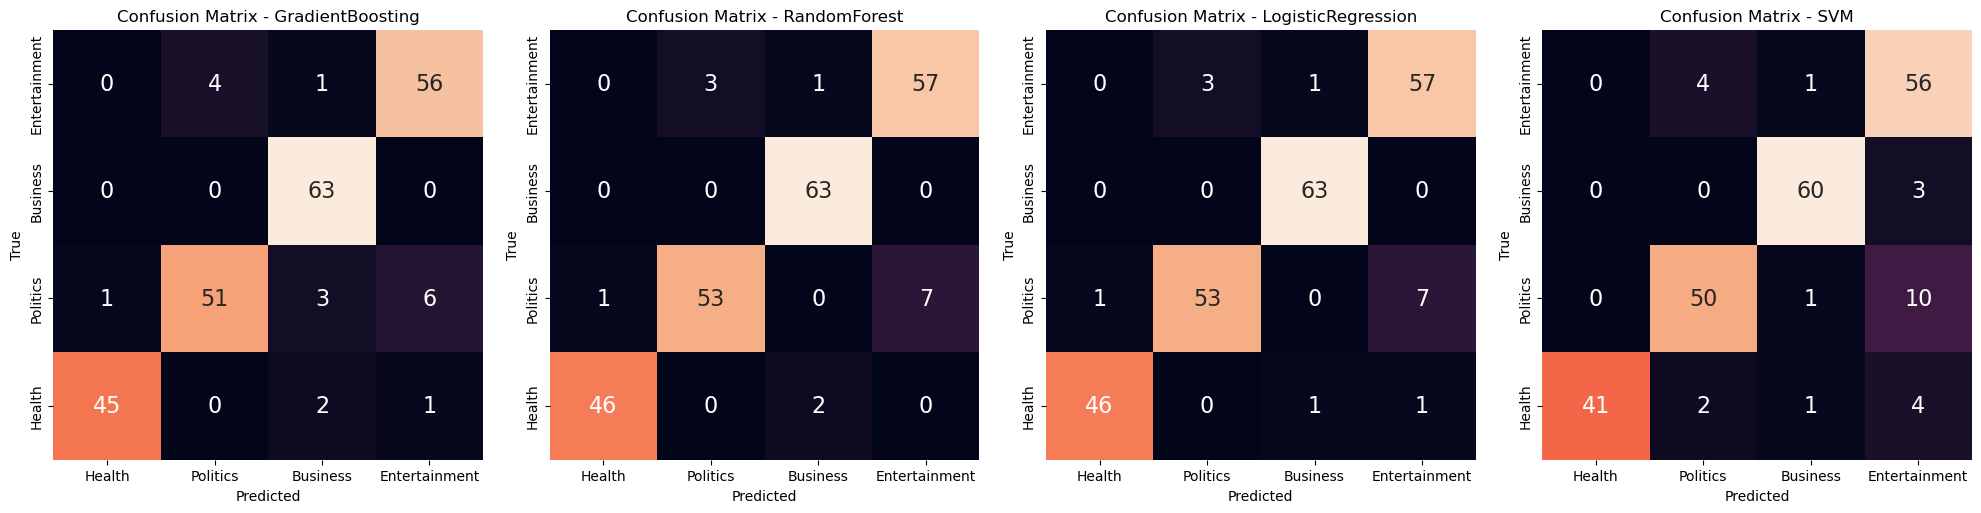

In [393]:
plot_confusion_matrices(confusion_matrices_TFIDF, [f'Confusion Matrix - {clf[0]}' for clf in classifiers])

#### **Word2Vec**

In [333]:
sentences = [sentence.split() for sentence in X_train]
#w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=0)
#w2v_model.save("word2vec_model.bin")

In [334]:
w2v_model = Word2Vec.load('word2vec_model.bin')

In [335]:
X_train_w2v = [vectorize(sentence, w2v_model) for sentence in X_train]
X_test_w2v = [vectorize(sentence, w2v_model) for sentence in X_test]

In [336]:
X_train_w2v[0]

array([-0.22307627,  0.3100381 ,  0.0795587 ,  0.00623555, -0.11684978,
       -0.44588798,  0.12079688,  0.5930172 , -0.15202735, -0.15266623,
       -0.14108303, -0.4439962 , -0.15012442,  0.03996506,  0.1297239 ,
       -0.28747874,  0.03690426, -0.33871287, -0.05334615, -0.4614616 ,
        0.13981399,  0.16195115,  0.22571662, -0.14577438, -0.12496361,
        0.06503905, -0.30403027, -0.18629499, -0.16553997, -0.00853885,
        0.21343575,  0.13994937,  0.00890179, -0.15185377,  0.05702296,
        0.29147637, -0.02454853, -0.3076764 , -0.13465968, -0.4512206 ,
       -0.01918242, -0.27630723, -0.17618027, -0.09307589,  0.18059534,
       -0.08925521, -0.31014487, -0.11213534,  0.12927002,  0.20200118,
        0.09235554, -0.22819108, -0.17909464,  0.07564814, -0.15628237,
        0.23564576,  0.11943276,  0.00766103, -0.25736016,  0.07678097,
        0.09457583,  0.05713455, -0.07793135,  0.03262632, -0.35991678,
        0.26968396,  0.01222104,  0.17533056, -0.2988127 ,  0.38

In [337]:
w2v_model.wv.key_to_index

{'health': 0,
 'said': 1,
 'cnn': 2,
 'business': 3,
 'new': 4,
 'year': 5,
 'election': 6,
 'people': 7,
 'also': 8,
 'republican': 9,
 'state': 10,
 'one': 11,
 'company': 12,
 'u': 13,
 'care': 14,
 'mental': 15,
 'trump': 16,
 'like': 17,
 'ad': 18,
 'american': 19,
 'video': 20,
 'pandemic': 21,
 'time': 22,
 'house': 23,
 'day': 24,
 'according': 25,
 'show': 26,
 'would': 27,
 'small': 28,
 'many': 29,
 'make': 30,
 'political': 31,
 'study': 32,
 'york': 33,
 'democrat': 34,
 'may': 35,
 'party': 36,
 'president': 37,
 'first': 38,
 'say': 39,
 'week': 40,
 'last': 41,
 'public': 42,
 'eating': 43,
 'service': 44,
 'movie': 45,
 'get': 46,
 'biden': 47,
 'content': 48,
 'help': 49,
 'way': 50,
 'store': 51,
 'even': 52,
 'group': 53,
 'could': 54,
 'life': 55,
 'need': 56,
 'since': 57,
 'worker': 58,
 'month': 59,
 'right': 60,
 'good': 61,
 'risk': 62,
 'food': 63,
 'medium': 64,
 'country': 65,
 'streaming': 66,
 'voter': 67,
 'issue': 68,
 'world': 69,
 'found': 70,
 'work'

In [338]:
report_Word2Vec, confusion_matrices_Word2Vec = classification(X_train_w2v, y_train, X_test_w2v, y_test, 'Word2Vec', classifiers)

In [339]:
report_Word2Vec

,Embedding,Classifier,Accuracy,Precision,Recall,F1,ROC-AUC
0,Word2Vec,RandomForest,0.759657,0.767536,0.759657,0.761009,0.923492
1,Word2Vec,LogisticRegression,0.480687,0.515170,0.480687,0.464449,0.654190
2,Word2Vec,SVM,0.283262,0.673059,0.283262,0.180208,0.584723
3,Word2Vec,GradientBoosting,0.759657,0.765677,0.759657,0.760320,0.928346


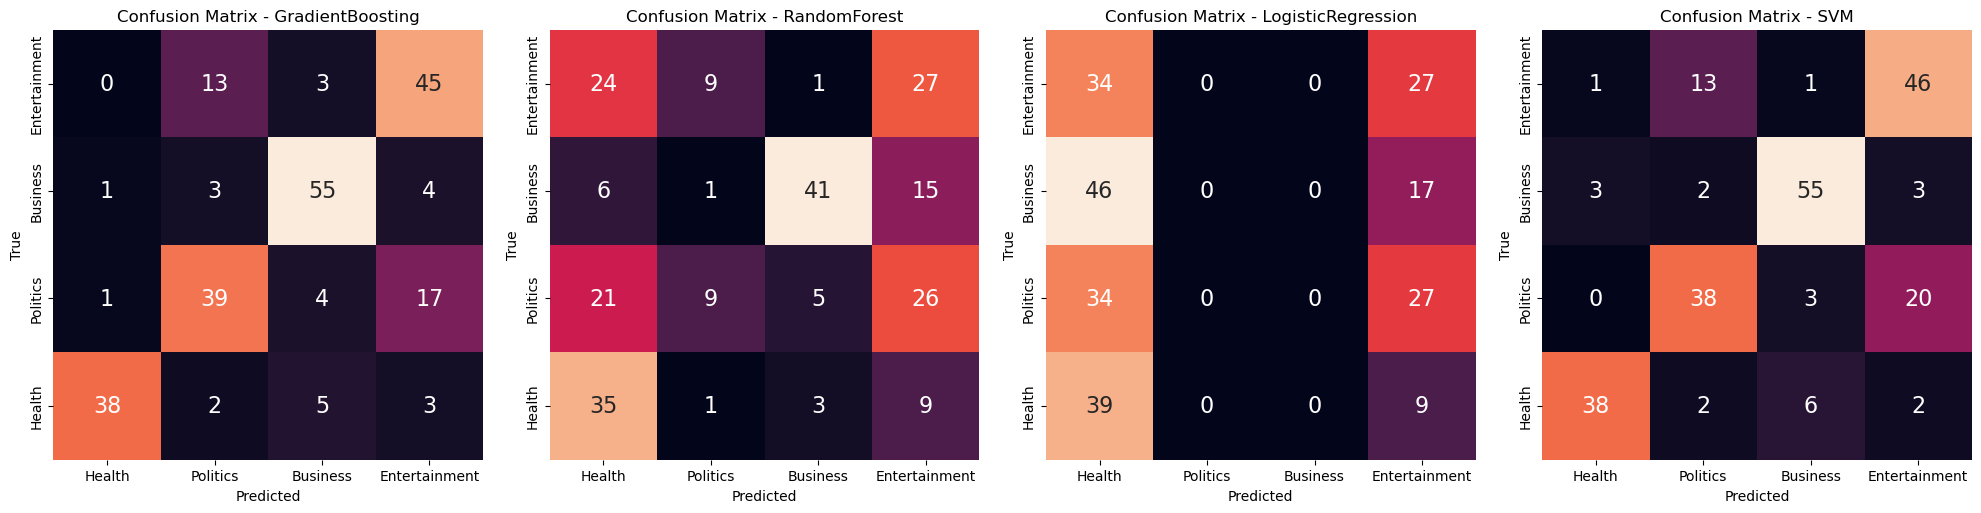

In [386]:
plot_confusion_matrices(confusion_matrices_Word2Vec, [f'Confusion Matrix - {clf[0]}' for clf in classifiers])

Doc2Vec

In [341]:
#tagged_data = []
#for index, row in data.iterrows():
    #words = word_tokenize(row['Cleaned_texts'].lower())  
    #tags = [row['Category']]  # Using the category label as the tag
    #tagged_data.append(TaggedDocument(words=words, tags=tags))

#d2v_model = Doc2Vec(vector_size=100, window=5, min_count=5, workers=4, epochs=100)
#d2v_model.build_vocab(tagged_data)
#d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
#d2v_model.save("doc2vec_model.bin")

In [342]:
d2v_model = Doc2Vec.load('doc2vec_model.bin')

In [343]:
X_train_d2v = [vectorize(sentence, d2v_model) for sentence in X_train]
X_test_d2v = [vectorize(sentence, d2v_model) for sentence in X_test]

In [344]:
report_Doc2Vec, confusion_matrices_Doc2Vec = classification(X_train_d2v, y_train, X_test_d2v, y_test,'Doc2Vec', classifiers)

In [345]:
report_Doc2Vec

,Embedding,Classifier,Accuracy,Precision,Recall,F1,ROC-AUC
0,Doc2Vec,RandomForest,0.845494,0.849041,0.845494,0.843520,0.956915
1,Doc2Vec,LogisticRegression,0.854077,0.857658,0.854077,0.852819,0.969841
2,Doc2Vec,SVM,0.862661,0.868314,0.862661,0.861032,0.974206
3,Doc2Vec,GradientBoosting,0.841202,0.841346,0.841202,0.840437,0.959231


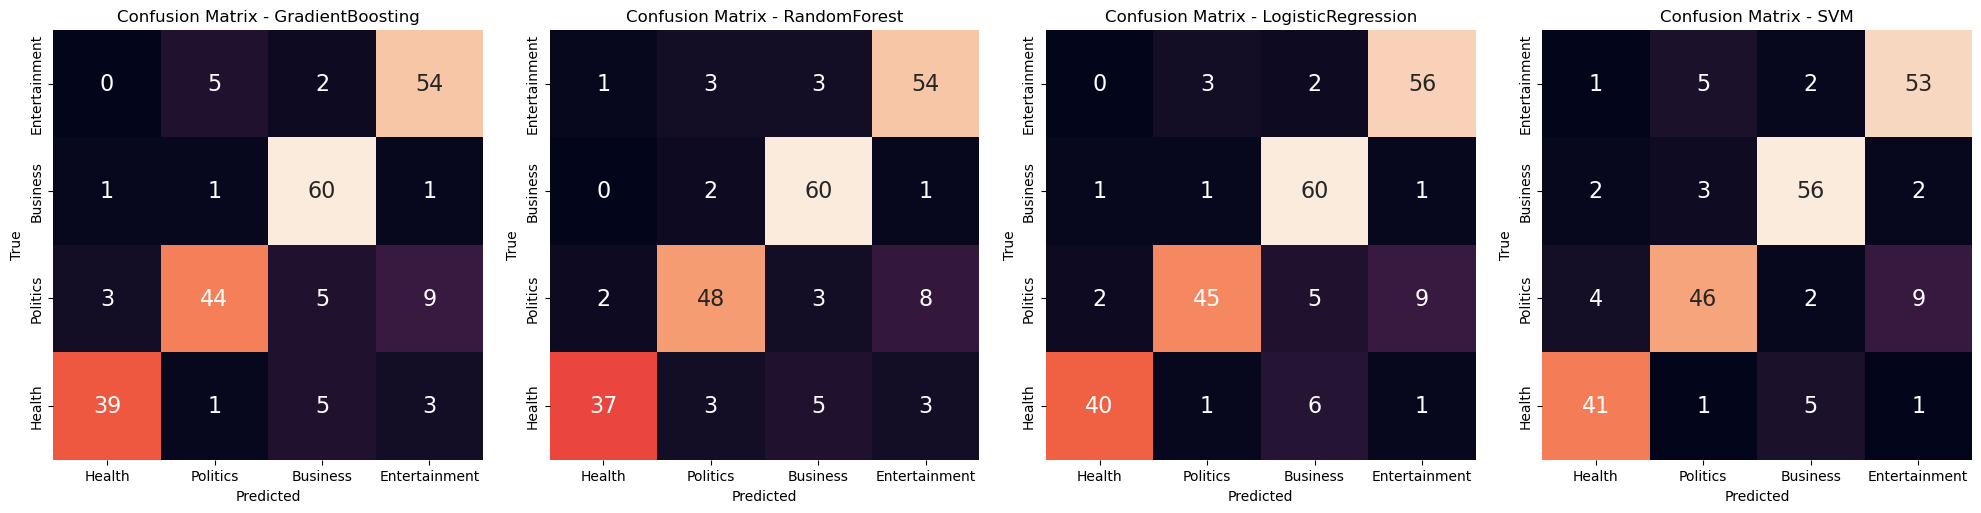

In [387]:
plot_confusion_matrices(confusion_matrices_Doc2Vec, [f'Confusion Matrix - {clf[0]}' for clf in classifiers])

In [394]:
results_df = pd.concat([report_TFIDF, report_Word2Vec, report_Doc2Vec], ignore_index=True)
results_df

,Embedding,Classifier,Accuracy,Precision,Recall,F1,ROC-AUC
0,TFIDF,RandomForest,0.922747,0.923880,0.922747,0.922011,0.979743
1,TFIDF,LogisticRegression,0.939914,0.940667,0.939914,0.939554,0.986963
2,TFIDF,SVM,0.939914,0.941050,0.939914,0.939722,0.974837
3,TFIDF,GradientBoosting,0.888412,0.898106,0.888412,0.889899,0.982838
4,Word2Vec,RandomForest,0.759657,0.767536,0.759657,0.761009,0.923492
5,Word2Vec,LogisticRegression,0.480687,0.515170,0.480687,0.464449,0.654190
6,Word2Vec,SVM,0.283262,0.673059,0.283262,0.180208,0.584723
7,Word2Vec,GradientBoosting,0.759657,0.765677,0.759657,0.760320,0.928346
8,Doc2Vec,RandomForest,0.845494,0.849041,0.845494,0.843520,0.956915
9,Doc2Vec,LogisticRegression,0.854077,0.857658,0.854077,0.852819,0.969841


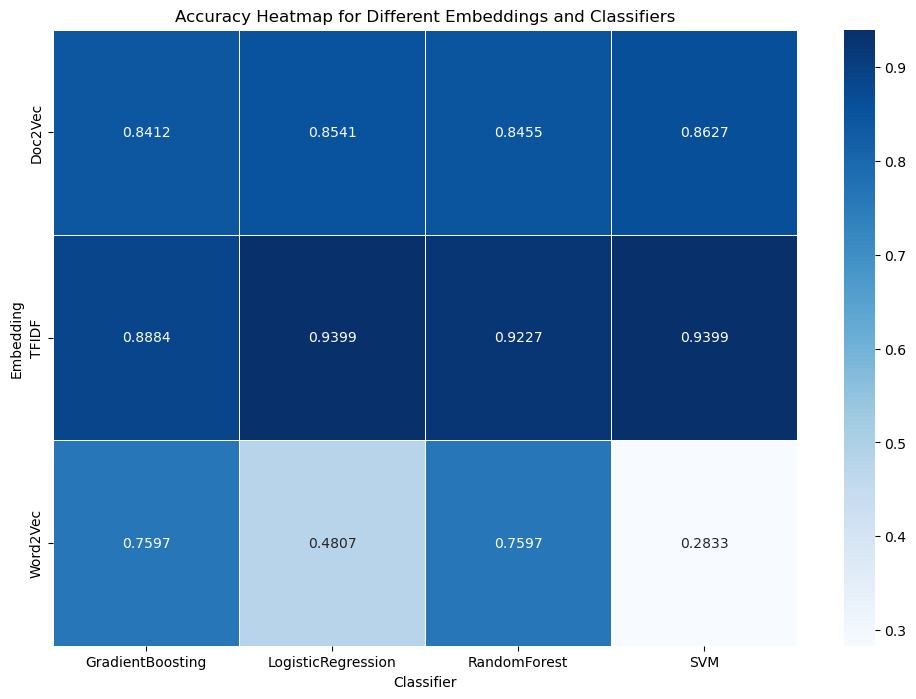

In [400]:
heatmap_data = results_df.groupby(['Embedding', 'Classifier']).mean()['Accuracy'].unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".4f", linewidths=.5)
plt.title('Accuracy Heatmap for Different Embeddings and Classifiers')
plt.show()

The accuracy heatmap for different embeddings and classifiers immediately reveals that the TF-IDF embedding technique outperforms others, as the classifiers achieve higher accuracy scores with TF-IDF. However, determining the best classifier is still uncertain. For instance, the Support Vector Machine (SVM) shows a high accuracy of 94% as well as the Logistic Regression, but this may be influenced by the randomness in how the training and testing datasets are split or by the classifiers's hyperparameters.

To address this uncertainty and select the best model, I am considering the Stratified K-Fold technique. By utilizing different folds, I aim to obtain a more robust estimate of each classifier's performance. This approach helps mitigate any potential misleading effects arising from how the dataset is partitioned. The goal is to make a more confident assessment of the classifier's performance across various data subsets.

In [349]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [396]:
num_folds = 5
results_list = []

for classifier_name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train_tfidf, y_train, cv=StratifiedKFold(n_splits=num_folds), scoring='accuracy')
    
    for fold_num, score in enumerate(scores, start=1):
        results_list.append({
            'Classifier': classifier_name,
            'Fold': fold_num,
            'Accuracy': score
        })

results_df_cv = pd.DataFrame(results_list)

In [401]:
results_df_cv

,Classifier,Fold,Accuracy
0,RandomForest,1,0.946524
1,RandomForest,2,0.866310
2,RandomForest,3,0.881720
3,RandomForest,4,0.935484
4,RandomForest,5,0.924731
5,LogisticRegression,1,0.962567
6,LogisticRegression,2,0.903743
7,LogisticRegression,3,0.913978
8,LogisticRegression,4,0.940860
9,LogisticRegression,5,0.913978


In [402]:
mean_accuracies = results_df_cv.groupby(['Classifier'])['Accuracy'].mean().reset_index()

In [403]:
mean_accuracies

,Classifier,Accuracy
0,GradientBoosting,0.887333
1,LogisticRegression,0.927025
2,RandomForest,0.910954
3,SVM,0.925944


After applying the Stratified K-Fold cross-validation technique, the result highlight the Logistic Regression as the leading classifier, even though its accuracy is less pronunced than before.

In summary, the optimal approach for news classification involves leveraging the TF-IDF embedding technique followed by the application of the Logistic Regression. This combinations consistently demonstrate superior performance, making it the preferred choice for accurate and reliable news categorization. 

## Neural network

Importing the necessary libraries. 

In [354]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Embedding,  GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

At this stage, I am exploring an alternative approach for both the embedding and classifier using Neural Networks. However, implementing a Neural Network for text data involves to tret them differently. 

In [355]:
data.head()

,Category,Full_description,Title,Cleaned_texts,Labels
0,Politics,What should be sending alarm bells through the...,Here’s why Democrats should be worried about t...,sending alarm bell white house democratic circ...,0
1,Politics,"Italian Prime Minister Giorgia Meloni, center,...",Opinion: What 2022’s elections taught me about...,italian prime minister giorgia meloni center f...,0
2,Politics,CNN —Most people don’t want to work into their...,"The consequences of old, powerful politicians ...",people want work powerful washington refuse le...,0
3,Politics,CNN —After the attack on the US Capitol on Jan...,Opinion: A dangerous trend for election disinf...,attack u capitol january tech company cracked ...,0
4,Politics,“Governors are uniquely positioned to take thi...,Bipartisan governors challenge Americans to di...,governor uniquely positioned take actually get...,0


In [356]:
X = data['Cleaned_texts']
y = data['Labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #random_state=42 for reproducability

This code employs the Keras **Tokenizer** for text data preprocessing. After creating a Tokenizer instance, it fits the training text data (X_train) to build a corresponding vocabulary. Subsequently, it converts the training text data into sequences of integers based on the acquired vocabulary. The same vocabulary is then applied to transform the test text data (X_test) into corresponding integer sequences. 

In [357]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [358]:
max(len(seq) for seq in sequences)

508

In [359]:
print(X_train[2])
print(sequences[2])

year felt like social medium landscape change much broke biggest buzziest social medium platform work run facebook looking community used furniture billion daily user around world tricky describe stereotypical facebook user pinterest looking inspirationpinterest let user easily search organize inspiration wide range creative topic twitter aka x looking going year twitter central hub news
[5, 1220, 17, 73, 64, 2791, 87, 103, 1221, 252, 5081, 73, 64, 382, 71, 326, 596, 400, 100, 288, 5082, 72, 538, 635, 131, 69, 5083, 1917, 5084, 596, 635, 5085, 400, 5086, 453, 635, 1693, 1347, 5087, 3570, 1348, 714, 1502, 1694, 401, 5088, 1503, 400, 132, 5, 401, 677, 2268, 191]


In [360]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[0]])
seq_lens = [len(s) for s in sequences]

print("Average length: %0.1f" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))

Found 9849 unique tokens.
Average length: 62.2
Max length: 508


This code pads sequences in the training and test sets to a maximum length of 179 using zeros ('post' padding). It ensures uniform sequence length, preparing the data for input to a neural network.

In [361]:
X_train = pad_sequences(sequences, maxlen=508, padding='post')
X_test = pad_sequences(sequences_test, maxlen=508, padding='post')

print('Shape pf data tensor:', X_train.shape)
print('Shape pf data tensor:', X_test.shape)

Shape pf data tensor: (932, 508)
Shape pf data tensor: (233, 508)


In [362]:
print(X_train[0, :])

[ 561   93   21 1501  534  882   15    1  323 3564  535    3  324   61
  233  562   15    1  452  950 5076  136 2262 1343 1021 1344 2263 3565
   96  165  219  130 1021  536 3566 1916 2264   15    1 1345   40  563
 2265 2266   15    1 5077   86    7  674   15    1  189   21  114  883
 5078  564  884 3567 1219   15    1   65  399    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [363]:
X_test

array([[1468, 1949,  692, ...,    0,    0,    0],
       [ 302,  379, 1577, ...,    0,    0,    0],
       [   4,   34,    3, ...,    0,    0,    0],
       ...,
       [  19,  180, 2880, ...,    0,    0,    0],
       [ 214,    3, 1292, ...,    0,    0,    0],
       [ 354,   11,  166, ...,    0,    0,    0]])

In [364]:
y_train_encoded = to_categorical(np.asanyarray(y_train))
print('Shape of label tensor:', y_train_encoded.shape)

Shape of label tensor: (932, 4)


In [365]:
from keras.backend import clear_session
clear_session()

The neural network below is created using tensorflow, the stages are described in the python cell. 

In [366]:
# Early stopping callback to stop training when a monitored metric has stopped improving, in this case the accuracy 
early_stopping = EarlyStopping()

# Input layer for sequences of integers with a specified length
sequence_input = Input(shape=(508,), dtype='int32')

# Embedding layer with vocabulary size 9850 (vocab_size + 1), embedding dimension 64, and sequence length 508. The layer is trainable, allowing the model to adjust the embeddings during training.
embedding_layer = Embedding(9850, 64, input_length=508, trainable = True)
embedded_sequence = embedding_layer(sequence_input)

#Global Average Pooling layer to reduce the sequence dimensionality to a fixed length.
average = GlobalAveragePooling1D()(embedded_sequence)

#Dense layer with softmax activation for multiclass classification into 4 classes.
predictions = Dense(4, activation='softmax')(average)

# Define the neural network model with input and output layers
model = Model(sequence_input, predictions)

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [367]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 508)]             0         
                                                                 
 embedding (Embedding)       (None, 508, 64)           630400    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 630660 (2.41 MB)
Trainable params: 630660 (2.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
14/14 [==============================] - 1s 44ms/step - loss: 1.3862 - accuracy: 0.2625 - val_loss: 1.3848 - val_accuracy: 0.2553
Epoch 2/20
14/14 [==============================] - 0s 23ms/step - loss: 1.3812 - accuracy: 0.2721 - val_loss: 1.3807 - val_accuracy: 0.2553
Epoch 3/20
 1/14 [=>............................] - ETA: 0s - loss: 1.3778 - accuracy: 0.2344

14/14 [==============================] - 0s 21ms/step - loss: 1.3776 - accuracy: 0.2721 - val_loss: 1.3776 - val_accuracy: 0.2660
Epoch 4/20
14/14 [==============================] - 0s 22ms/step - loss: 1.3737 - accuracy: 0.2721 - val_loss: 1.3746 - val_accuracy: 0.2660
Epoch 5/20
14/14 [==============================] - 0s 19ms/step - loss: 1.3697 - accuracy: 0.2721 - val_loss: 1.3723 - val_accuracy: 0.2660
Epoch 6/20
14/14 [==============================] - 0s 18ms/step - loss: 1.3653 - accuracy: 0.2721 - val_loss: 1.3695 - val_accuracy: 0.2660
Epoch 7/20
14/14 [==============================] - 0s 19ms/step - loss: 1.3601 - accuracy: 0.2721 - val_loss: 1.3667 - val_accuracy: 0.2660
Epoch 8/20
14/14 [==============================] - 0s 22ms/step - loss: 1.3544 - accuracy: 0.2733 - val_loss: 1.3626 - val_accuracy: 0.2660
Epoch 9/20
14/14 [==============================] - 0s 21ms/step - loss: 1.3479 - accuracy: 0.2745 - val_loss: 1.3551 - val_accuracy: 0.2660
Epoch 10/20
14/14 [=====

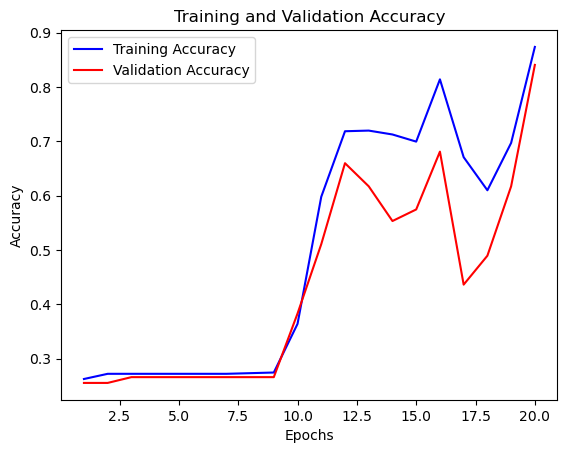

In [368]:
history = model.fit(X_train, 
                    y_train_encoded, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.1, 
                    callbacks=[early_stopping])

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [369]:
output = model.predict(X_test)
predicted_classes = np.argmax(output, axis=1)

8/8 [==============================] - 0s 3ms/step


In [370]:
f1 = f1_score(y_test, predicted_classes, average='weighted')
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
accuracy = accuracy_score(y_test, predicted_classes)

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

F1 Score: 0.83704791518227
Precision: 0.8450511090528402
Recall: 0.8412017167381974
Accuracy: 0.8412017167381974


The new combination of embedding and classifier does not achieve the outstanding results observed previously, as evident from the evaluation metrics.